# Credit

This Deep Markov Model tutorial implementation is based on the Pyro tutorial example found at https://pyro.ai/examples/dmm.html and https://github.com/pyro-ppl/pyro/blob/dev/examples/dmm.py, with detailed notes and comments added. A reference to the original paper that the Pyro tutorial was based on is included below.

**Reference:**  
Rahul G. Krishnan, Uri Shalit, David Sontag. Structured Inference Networks for Nonlinear State Space Models. arXiv:1609.09869

# Installs & Imports

In [1]:
!pip install -q pyro-ppl

In [2]:
import logging
import sys
import time
from os.path import exists

import numpy as np
import torch
import torch.nn as nn

import pyro
import pyro.contrib.examples.polyphonic_data_loader as poly
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.distributions import TransformedDistribution
from pyro.distributions.transforms import affine_autoregressive
from pyro.infer.enum import config_enumerate
from pyro.infer import (
    SVI,
    JitTrace_ELBO,
    Trace_ELBO,
    TraceEnum_ELBO,
    TraceTMC_ELBO
)
from pyro.optim import ClippedAdam

# Emitter

The Deep Markov Model (DMM) excels in modeling sequential data by capturing complex temporal patterns. A key component of the DMM is the Emitter, which translates the model's latent states (z_t) into observable data (x_t) using a conditional probability distribution. These latent states, encapsulating the data's underlying dynamics, evolve according to a Markov process, with the Emitter decoding this progression into observable sequences.

The Emitter's design involves selecting an appropriate output distribution and constructing a neural network to map latent states to observations. This process ensures the Emitter can accurately reflect the complex relationships between latent states and observed data, making it fundamental to the DMM's ability to infer and generate data sequences.

In [3]:
class Emitter(nn.Module):
    """
    The Emitter class parameterizes the observation likelihood in a probabilistic model,
    specifically modeling the likelihood `p(x_t | z_t)` of observations `x_t` given
    latent variables `z_t` for a particular time step `t`. This implementation uses
    a neural network to transform the latent variable into a probability vector
    for Bernoulli distributions over observed variables.
    """

    def __init__(self, input_dim, z_dim, emission_dim):
        """
        Initializes the Emitter module.

        Parameters:
        - input_dim: int, dimensionality of the observation space.
        - z_dim: int, dimensionality of the latent variable space.
        - emission_dim: int, dimensionality of the hidden layer in the emission network.
        """
        super().__init__()

        # Initialize linear transformations used in the neural network
        # These transformations map the latent space to the hidden layer,
        # then to another hidden layer, and finally to the observation space
        self.lin_z_to_hidden = nn.Linear(z_dim, emission_dim)  # Maps z_t to the hidden layer
        self.lin_hidden_to_hidden = nn.Linear(emission_dim, emission_dim)  # Maps within the hidden layer for additional processing
        self.lin_hidden_to_input = nn.Linear(emission_dim, input_dim)  # Maps from hidden layer to observation space

        # Initialize non-linear activations to introduce non-linearities into the model,
        # making it capable of representing more complex functions
        self.relu = nn.ReLU()  # ReLU is used for its simplicity and effectiveness in many neural network architectures

    def forward(self, z_t):
        """
        Defines the forward pass of the Emitter module.

        Given the latent variable `z_t` at time step `t`, this method computes
        and returns the vector of probabilities `ps` that parameterize the Bernoulli
        distribution `p(x_t|z_t)` over the observations.

        Parameters:
        - z_t: Tensor, the latent variable at time step `t`.

        Returns:
        - ps: Tensor, the vector of probabilities parameterizing the observation likelihood.
        """
        # Transform the latent variable `z_t` through the first linear layer and apply ReLU
        h1 = self.relu(self.lin_z_to_hidden(z_t))

        # Further transform the output of the first layer through a second linear layer and ReLU
        h2 = self.relu(self.lin_hidden_to_hidden(h1))

        # Finally, transform the output of the second hidden layer to the observation space
        # and apply sigmoid to obtain probabilities
        ps = torch.sigmoid(self.lin_hidden_to_input(h2))

        return ps

# Gated Transition

The Gated Transition class in Deep Markov Models (DMMs) is pivotal for modeling the temporal evolution of latent states, z_t, based on their previous states, z_{t-1}. It employs a gating mechanism, similar to those in LSTMs and GRUs, to control the influence of the current state on the future state's prediction. This approach allows for complex, non-linear transitions essential for capturing the dynamics of real-world sequences.

This class parameterizes the transition as a Gaussian distribution, where both the mean and scale are dynamically computed from the previous state. The mean incorporates a gated combination of the previous state and a proposed mean, enabling flexible adjustment of the transition's direction and magnitude. The scale captures the uncertainty of the transition, reflecting the model's confidence in its predictions.

Neural networks within the Gated Transition learn these dynamics directly from data, optimizing weights through training to capture latent state evolutions. This capability makes DMMs versatile for applications like speech recognition and financial forecasting.

In summary, the Gated Transition class embodies the DMM's methodological blend of deep learning and probabilistic modeling, facilitating nuanced modeling of sequential data's temporal dependencies.

In [4]:
class GatedTransition(nn.Module):
    """
    This class models the transition dynamics in a latent space by parameterizing the
    conditional distribution `p(z_t | z_{t-1})`, where `z_t` is the latent state at time t,
    given the previous latent state `z_{t-1}`. This parameterization is crucial for
    capturing the temporal dependencies within the latent space of a sequence model.

    The transition is modeled as a Gaussian distribution with a mean and scale that
    are functions of the previous latent state, incorporating a gating mechanism to
    allow for complex, non-linear transitions.
    """

    def __init__(self, z_dim, transition_dim):
        """
        Initializes the GatedTransition module with the necessary layers.

        Parameters:
        - z_dim: int, the dimensionality of the latent space.
        - transition_dim: int, the dimensionality of the intermediate representations
          within the gating mechanism.
        """
        super().__init__()

        # Linear transformations for the gating mechanism
        self.lin_gate_z_to_hidden = nn.Linear(z_dim, transition_dim)  # Transforms z_{t-1} to an intermediate representation for the gate
        self.lin_gate_hidden_to_z = nn.Linear(transition_dim, z_dim)  # Determines the gating values based on the intermediate representation

        # Linear transformations for proposing the mean of the transition
        self.lin_proposed_mean_z_to_hidden = nn.Linear(z_dim, transition_dim)  # Transforms z_{t-1} to propose a mean value for z_t
        self.lin_proposed_mean_hidden_to_z = nn.Linear(transition_dim, z_dim)  # Finalizes the proposed mean value for z_t

        # Additional linear transformation for the scale parameter
        self.lin_sig = nn.Linear(z_dim, z_dim)  # Used in computing the scale of the Gaussian distribution

        # Linear transformation used in the computation of the actual mean, initialized
        # to act approximately as an identity function at the start
        self.lin_z_to_loc = nn.Linear(z_dim, z_dim)
        self.lin_z_to_loc.weight.data = torch.eye(z_dim)  # Initialization to approximate identity function
        self.lin_z_to_loc.bias.data = torch.zeros(z_dim)

        # Non-linear activation functions.
        self.relu = nn.ReLU()  # Used for intermediate non-linear transformations
        self.softplus = nn.Softplus()  # Ensures the scale parameter is positive

    def forward(self, z_t_1):
        """
        Defines the forward pass through the GatedTransition module.

        Given the latent state `z_{t-1}` at the previous time step, this method computes
        the mean (`loc`) and scale (`scale`) that parameterize the Gaussian distribution
        for the next latent state `z_t`.

        Parameters:
        - z_t_1: Tensor, the latent state at the previous time step t-1.

        Returns:
        - loc: Tensor, the mean vector of the Gaussian distribution for z_t.
        - scale: Tensor, the scale vector of the Gaussian distribution for z_t.
        """
        # Compute the gating function to modulate contributions between the previous state and the proposed mean
        _gate = self.relu(self.lin_gate_z_to_hidden(z_t_1))
        gate = torch.sigmoid(self.lin_gate_hidden_to_z(_gate))

        # Compute the proposed mean for the next latent state
        _proposed_mean = self.relu(self.lin_proposed_mean_z_to_hidden(z_t_1))
        proposed_mean = self.lin_proposed_mean_hidden_to_z(_proposed_mean)

        # Compute the actual mean as a gated combination of the previous latent state and the proposed mean
        loc = (1 - gate) * self.lin_z_to_loc(z_t_1) + gate * proposed_mean

        # Compute the scale, ensuring it is positive, to parameterize the Gaussian distribution
        scale = self.softplus(self.lin_sig(self.relu(proposed_mean)))

        return loc, scale

# Combiner

The Combiner class in DMMs crucially integrates past latent states and future observed data to enhance the model's predictive accuracy. It parameterizes the variational distribution q(zt | zt−1, xt:T), capturing the model's belief about the latent state at time t, based on both the immediate past latent state and subsequent observations. This dual dependency enables the DMM to utilize the entire available context, enriching the representation of system dynamics.

By synthesizing latent and observed information, the Combiner helps the DMM make informed predictions, especially when future observations contain vital insights about upcoming states. This synthesis is accomplished through an RNN that processes observed data, condensing it into a hidden state that, along with the previous latent state, informs the next state's prediction.

The Combiner employs linear transformations and non-linear activations to compute the parameters of a Gaussian distribution for the next latent state. This method allows for a dynamic and nuanced approach to modeling the transitions between latent states, taking into account the complexities of real-world data.

In essence, the Combiner embodies the application of variational inference in DMMs, facilitating a deep understanding of sequential data by marrying historical latent state information with future observations. Its operation is essential for the adaptability and precision of DMMs in various applications.

In [5]:
class Combiner(nn.Module):
    """
    The Combiner module plays a pivotal role in variational inference by parameterizing
    the variational distribution `q(z_t | z_{t-1}, x_{t:T})`. This distribution models
    the posterior over the latent variables `z_t` at time `t`, given the previous latent
    state `z_{t-1}` and the observations from time `t` to `T` (`x_{t:T}`). The key feature
    of this module is its ability to integrate information from both the latent state
    and the observed data sequence through the hidden state of an RNN, enabling the
    model to capture complex temporal dependencies.
    """

    def __init__(self, z_dim, rnn_dim):
        """
        Initializes the Combiner module with the necessary layers and dimensions.

        Parameters:
        - z_dim: int, dimensionality of the latent space.
        - rnn_dim: int, dimensionality of the RNN's hidden state.
        """
        super().__init__()

        # Linear transformations are employed to manipulate the latent state and RNN's hidden state
        self.lin_z_to_hidden = nn.Linear(z_dim, rnn_dim)  # Transforms the latent state `z_{t-1}` for combination
        self.lin_hidden_to_loc = nn.Linear(rnn_dim, z_dim)  # Computes the location (mean) parameter of the Gaussian distribution
        self.lin_hidden_to_scale = nn.Linear(rnn_dim, z_dim)  # Computes the scale (variance) parameter of the Gaussian distribution

        # Non-linearities introduce the ability to capture more complex patterns in the data
        self.tanh = nn.Tanh()  # Used for blending latent and observed information
        self.softplus = nn.Softplus()  # Ensures the scale parameter is positive, a requirement for the variance of a Gaussian distribution

    def forward(self, z_t_1, h_rnn):
        """
        Defines the forward pass of the Combiner module.

        Integrates information from the previous latent state `z_{t-1}` and the
        hidden state of the RNN `h(x_{t:T})` to compute parameters for the
        variational distribution `q(z_t | z_{t-1}, x_{t:T})`.

        Parameters:
        - z_t_1: Tensor, the latent state at the previous time step `t-1`.
        - h_rnn: Tensor, the hidden state of the RNN summarizing the observations from `t` to `T`.

        Returns:
        - loc: Tensor, the mean vector of the Gaussian distribution for `z_t`.
        - scale: Tensor, the scale (standard deviation) vector of the Gaussian distribution for `z_t`.
        """
        # Combine the transformed latent state and the RNN hidden state
        # This combination serves as a way to incorporate both prior latent information
        # and observed data into the estimation of the current latent state
        h_combined = 0.5 * (self.tanh(self.lin_z_to_hidden(z_t_1)) + h_rnn)

        # Compute the mean (loc) of the Gaussian distribution for the current latent state
        loc = self.lin_hidden_to_loc(h_combined)

        # Compute the scale (variance) of the Gaussian distribution for the current latent state
        # The softplus function ensures the scale is positive
        scale = self.softplus(self.lin_hidden_to_scale(h_combined))

        return loc, scale

# DMM Module

The Deep Markov Model (DMM) combines deep learning and probabilistic modeling to analyze sequential data, revealing underlying patterns and temporal relationships. It's adept at navigating complex, nonlinear temporal connections across a variety of applications.

**Generative Model Component**

- Emitter: Translates latent states into observable data, generating data points that align with underlying latent dynamics.
    
- Gated Transition: Manages the evolution of latent states, ensuring coherent progression reflective of the system's complexity.
    
- RNN and Initial States: The RNN captures thematic elements and nuances over time, while initial states provide the narrative's starting conditions.

**Variational Guide Component**

- Combiner: Integrates past latent states with incoming data to refine predictions, balancing historical and emergent information.

- RNN: Summarizes the data sequence, supporting the Combiner by linking observed data with inferred latent states.

**Integration and Learning**

DMMs leverage the interplay between their generative model and variational guide to refine their understanding of observed sequences, optimizing the evidence lower bound (ELBO). This process enhances the model's predictive capabilities and deepens insights into the latent dynamics underpinning the data.

In [6]:
class DMM(nn.Module):
    """
    The DMM class represents a Deep Markov Model, a type of deep generative model that combines
    deep learning with probabilistic graphical modeling. It captures temporal dynamics and dependencies
    within sequence data by modeling the sequence both at the observed level and in a latent space.

    This implementation includes both the generative model (p) that describes how data is generated
    and the variational distribution (q), also known as the guide, which approximates the posterior
    distribution over latent variables given observed data.
    """

    def __init__(
        self,
        input_dim=88,
        z_dim=100,
        emission_dim=100,
        transition_dim=200,
        rnn_dim=600,
        num_layers=1,
        rnn_dropout_rate=0.0,
        num_iafs=0,
        iaf_dim=50,
        use_cuda=False,
    ):
        """
        Initializes the Deep Markov Model with specified dimensions and configurations.

        Parameters:
        - input_dim (int): Dimensionality of the observed data.
        - z_dim (int): Dimensionality of the latent space.
        - emission_dim (int): Size of the hidden layer in the emission network.
        - transition_dim (int): Size of the hidden layer in the transition network.
        - rnn_dim (int): Size of the hidden layers in the RNN.
        - num_layers (int): Number of layers in the RNN.
        - rnn_dropout_rate (float): Dropout rate for RNN layers (except the last layer).
        - num_iafs (int): Number of Inverse Autoregressive Flows (IAFs) to use.
        - iaf_dim (int): Dimensionality of the hidden layers in each IAF.
        - use_cuda (bool): Whether to use CUDA (GPU acceleration) if available.
        """
        super().__init__()

        # Core components of the DMM
        self.emitter = Emitter(input_dim, z_dim, emission_dim)  # Models p(x_t | z_t)
        self.trans = GatedTransition(z_dim, transition_dim)  # Models p(z_t | z_{t-1})
        self.combiner = Combiner(z_dim, rnn_dim)  # Models q(z_t | z_{t-1}, x_{t:T})

        # Configure RNN with dropout as specified
        rnn_dropout_rate = 0.0 if num_layers == 1 else rnn_dropout_rate
        self.rnn = nn.RNN(
            input_size=input_dim,
            hidden_size=rnn_dim,
            nonlinearity="relu",
            batch_first=True,
            bidirectional=False,
            num_layers=num_layers,
            dropout=rnn_dropout_rate,
        )

        # Normalizing flows (IAFs) for more flexible variational distributions
        self.iafs = [affine_autoregressive(z_dim, hidden_dims=[iaf_dim]) for _ in range(num_iafs)]
        self.iafs_modules = nn.ModuleList(self.iafs)

        # Initial latent state and initial variational distribution parameters
        self.z_0 = nn.Parameter(torch.zeros(z_dim))  # Initial latent state for p(z_1)
        self.z_q_0 = nn.Parameter(torch.zeros(z_dim))  # Initial latent state for q(z_1)

        # Initial hidden state for the RNN
        self.h_0 = nn.Parameter(torch.zeros(1, 1, rnn_dim))

        # Utilize CUDA if specified and available
        self.use_cuda = use_cuda
        if use_cuda:
            self.cuda()

    def model(
        self,
        mini_batch,
        mini_batch_reversed,
        mini_batch_mask,
        mini_batch_seq_lengths,
        annealing_factor=1.0,
    ):
        """
        Defines the generative model component of the DMM. This method encapsulates the
        generative process for the sequence of observations based on the latent variables,
        essentially specifying the joint distribution p(x_{1:T}, z_{1:T}) over observed data
        and latent variables for the entire sequence.

        Parameters:
        - mini_batch: A batch of observed sequences, shaped as (batch_size, T_max, input_dim),
        where `T_max` is the maximum sequence length in the batch.
        - mini_batch_reversed: Not directly used in this method, but provided for consistency
        with the guide method signature.
        - mini_batch_mask: A mask indicating the actual lengths of sequences within the mini_batch
        to handle variable-length sequences, shaped as (batch_size, T_max).
        - mini_batch_seq_lengths: The lengths of each sequence within the mini_batch.
        - annealing_factor: A scaling factor for the KL divergence term used in training to
        facilitate easier optimization in the early stages of training (KL annealing).
        """
        # Determine the maximum number of time steps in this mini-batch
        T_max = mini_batch.size(1)

        # Ensure all PyTorch modules are registered with Pyro, necessary for Pyro's optimization
        pyro.module("dmm", self)

        # Initialize the latent state for the first time step
        z_prev = self.z_0.expand(mini_batch.size(0), self.z_0.size(0))

        # Process each sequence in the mini-batch independently
        with pyro.plate("z_minibatch", len(mini_batch)):
            # Sequentially sample latent states and observed data for each time step
            for t in pyro.markov(range(1, T_max + 1)):
                # Compute the parameters (mean and scale) for the latent state at time t,
                # based on the previous latent state (z_{t-1})
                z_loc, z_scale = self.trans(z_prev)

                # Sample the latent state z_t from the Gaussian distribution parameterized
                # by z_loc and z_scale, applying KL annealing and handling variable sequence lengths
                with poutine.scale(scale=annealing_factor):
                    z_t = pyro.sample(
                        f"z_{t}",
                        dist.Normal(z_loc, z_scale)
                        .mask(mini_batch_mask[:, t - 1 : t])
                        .to_event(1),
                    )

                # Compute the probabilities parameterizing the Bernoulli distribution for observed data at time t
                emission_probs_t = self.emitter(z_t)

                # Sample the observed data x_t from the Bernoulli distribution parameterized
                # by the emission probabilities, respecting the sequence mask
                pyro.sample(
                    f"obs_x_{t}",
                    dist.Bernoulli(emission_probs_t)
                    .mask(mini_batch_mask[:, t - 1 : t])
                    .to_event(1),
                    obs=mini_batch[:, t - 1, :],
                )

                # Update z_prev to the current latent state for the next time step
                z_prev = z_t

    def guide(
        self,
        mini_batch,
        mini_batch_reversed,
        mini_batch_mask,
        mini_batch_seq_lengths,
        annealing_factor=1.0,
    ):
        """
        Specifies the variational distribution (guide) q(z_{1:T} | x_{1:T}) for the Deep Markov Model (DMM).
        This method approximates the posterior distribution over the latent variables given the observed
        data sequences. It leverages an RNN to process the observed data, capturing temporal dependencies
        and informing the variational distribution at each time step.

        Parameters:
        - mini_batch: Tensor, the observed data sequences, shaped as (batch_size, T_max, input_dim).
        - mini_batch_reversed: Tensor, the observed data sequences in reverse order, utilized by the RNN.
        - mini_batch_mask: Tensor, a mask to handle variable-length sequences within the mini_batch.
        - mini_batch_seq_lengths: Tensor, the lengths of each sequence in the mini_batch.
        - annealing_factor: float, used to scale the KL divergence term in the ELBO during optimization.
        """
        # Determine the maximum sequence length in this mini-batch
        T_max = mini_batch.size(1)

        # Ensure all PyTorch modules within the DMM are registered with Pyro for optimization
        pyro.module("dmm", self)

        # Prepare the initial RNN hidden state, ensuring it's compatible with GPU execution if enabled
        h_0_contig = self.h_0.expand(1, mini_batch.size(0), self.rnn.hidden_size).contiguous()

        # Process the reversed mini-batch through the RNN to capture the backward temporal dependencies
        rnn_output, _ = self.rnn(mini_batch_reversed, h_0_contig)
        # Reverse the RNN output to match the original temporal ordering and unpack based on sequence lengths
        rnn_output = poly.pad_and_reverse(rnn_output, mini_batch_seq_lengths)

        # Initialize the previous latent state for the first step of the guide
        z_prev = self.z_q_0.expand(mini_batch.size(0), self.z_q_0.size(0))

        # Process each data point in the mini-batch independently using a Pyro plate
        with pyro.plate("z_minibatch", len(mini_batch)):
            # Sequentially sample latent states informed by both previous latent states and observed data
            for t in pyro.markov(range(1, T_max + 1)):
                # Assemble the conditional variational distribution for the current latent state
                z_loc, z_scale = self.combiner(z_prev, rnn_output[:, t - 1, :])

                # Apply normalizing flows if specified, transforming the base distribution to enhance flexibility
                if len(self.iafs) > 0:
                    z_dist = TransformedDistribution(dist.Normal(z_loc, z_scale), self.iafs)
                else:
                    z_dist = dist.Normal(z_loc, z_scale).to_event(1)

                # Sample the current latent state from the specified distribution, applying annealing if configured
                with pyro.poutine.scale(scale=annealing_factor):
                    z_t = pyro.sample(f"z_{t}", z_dist.mask(mini_batch_mask[:, t - 1]))

                # Update the previous latent state to the current one for the next iteration
                z_prev = z_t

# Main

In [7]:
def main(args):
    """
    Main function to setup, train, and evaluate the Deep Markov Model (DMM).

    This function initializes logging, loads the dataset, prepares data for training,
    validation, and testing, and sets up the training loop including evaluation
    frequency and batch processing.

    Parameters:
    args (dict): A dictionary of configuration parameters including logging file,
    mini-batch size, evaluation frequency, etc.
    """

    # Clear any existing logging handlers
    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)

    # Set up logging to both file and console
    logging.basicConfig(level=logging.INFO,
                        format="%(asctime)s - %(levelname)s - %(message)s",
                        handlers=[
                            logging.FileHandler(args['log'], mode='w'),
                            logging.StreamHandler(sys.stdout)
                        ])

    logging.info("Configuration parameters: %s", args)

    # Load the dataset, segregating into training, validation, and test sets
    # JSB Chorales dataset is used for this sequence modeling task
    data = poly.load_data(poly.JSB_CHORALES)
    training_seq_lengths = data["train"]["sequence_lengths"]
    training_data_sequences = data["train"]["sequences"]
    test_seq_lengths = data["test"]["sequence_lengths"]
    test_data_sequences = data["test"]["sequences"]
    val_seq_lengths = data["valid"]["sequence_lengths"]
    val_data_sequences = data["valid"]["sequences"]

    # Compute key dataset metrics to inform training setup
    N_train_data = len(training_seq_lengths)  # Total number of training sequences
    N_train_time_slices = float(torch.sum(training_seq_lengths))  # Sum of all sequence lengths for normalization
    # Calculate the number of mini-batches based on the training data size and specified mini-batch size
    N_mini_batches = int(N_train_data / args['mini_batch_size'] + int(N_train_data % args['mini_batch_size'] > 0))

    # Log dataset metrics for reference.
    logging.info("N_train_data: %d     Avg. training seq. length: %.2f    N_mini_batches: %d" %
                 (N_train_data, training_seq_lengths.float().mean(), N_mini_batches))

    # Define evaluation frequency and setup for vectorized evaluation on validation and test data
    val_test_frequency = 50  # Frequency of evaluation on validation/test sets during training
    n_eval_samples = 1  # Number of samples to draw during evaluation for averaging

    def rep(x):
        """
        Replicates and reshapes the input tensor for vectorized evaluation.

        This function is designed to prepare the data for efficient batch processing
        during evaluation by replicating the input tensor a specified number of times
        (n_eval_samples) and rearranging it to match the expected input structure for
        the model. It facilitates faster evaluation by leveraging parallel computation
        capabilities.

        Parameters:
        x (Tensor): The input tensor to replicate and reshape.

        Returns:
        Tensor: The replicated and reshaped tensor.
        """
        # Define the new shape after replication. The first dimension is expanded
        # to include multiple copies (n_eval_samples) of the data
        rep_shape = torch.Size([x.size(0) * n_eval_samples]) + x.size()[1:]

        # Specify the dimensions to replicate. Only the first dimension (samples) is replicated
        repeat_dims = [1] * len(x.size())
        repeat_dims[0] = n_eval_samples  # Replicate each sample n_eval_samples times

        # Perform the replication and reshape operations to obtain the desired format
        return x.repeat(repeat_dims).reshape(n_eval_samples, -1).transpose(1, 0).reshape(rep_shape)

    # Prepare validation and test data for efficient, vectorized evaluation
    # This step optimizes the evaluation process by enabling batch processing
    val_seq_lengths = rep(val_seq_lengths)
    test_seq_lengths = rep(test_seq_lengths)

    # Use a utility function to organize the validation and test data into mini-batches
    # These mini-batches are then prepared for input into the Deep Markov Model (DMM)
    val_batch, val_batch_reversed, val_batch_mask, val_seq_lengths = poly.get_mini_batch(
        torch.arange(n_eval_samples * val_data_sequences.shape[0]),
        rep(val_data_sequences),
        val_seq_lengths,
        cuda=args['cuda'],
    )
    test_batch, test_batch_reversed, test_batch_mask, test_seq_lengths = poly.get_mini_batch(
        torch.arange(n_eval_samples * test_data_sequences.shape[0]),
        rep(test_data_sequences),
        test_seq_lengths,
        cuda=args['cuda'],
    )

    # Initialize the Deep Markov Model (DMM) with specified configuration parameters
    # This includes settings for dropout rates, the use of Inverse Autoregressive Flows (IAFs), and CUDA support
    dmm = DMM(
        rnn_dropout_rate=args['rnn_dropout_rate'],
        num_iafs=args['num_iafs'],
        iaf_dim=args['iaf_dim'],
        use_cuda=args['cuda'],
    )

    # Set up the optimizer with predefined parameters
    # The Adam optimizer is enhanced with clipping for gradient normalization
    adam_params = {
        "lr": args['learning_rate'],
        "betas": (args['beta1'], args['beta2']),
        "clip_norm": args['clip_norm'],
        "lrd": args['lr_decay'],
        "weight_decay": args['weight_decay'],
    }
    adam = ClippedAdam(adam_params)

    # Configure the inference algorithm based on the specified method (TMC, TMCElbo, or standard ELBO)
    # This setup determines how the model and guide are optimized during training
    if args['tmc']:
        if args['jit']:  # Just-In-Time compilation is not supported for TMC yet
            raise NotImplementedError("no JIT support yet for TMC")
        tmc_loss = TraceTMC_ELBO()
        dmm_guide = config_enumerate(dmm.guide, default="parallel", num_samples=args['tmc_num_samples'], expand=False)
        svi = SVI(dmm.model, dmm_guide, adam, loss=tmc_loss)
    elif args['tmcelbo']:
        if args['jit']:  # Just-In-Time compilation is not supported for TMCElbo yet
            raise NotImplementedError("no JIT support yet for TMC ELBO")
        elbo = TraceEnum_ELBO()
        dmm_guide = config_enumerate(dmm.guide, default="parallel", num_samples=args['tmc_num_samples'], expand=False)
        svi = SVI(dmm.model, dmm_guide, adam, loss=elbo)
    else:
        elbo = JitTrace_ELBO() if args['jit'] else Trace_ELBO()  # Choose the appropriate ELBO variant
        svi = SVI(dmm.model, dmm.guide, adam, loss=elbo)

    def save_checkpoint():
        """
        Saves the current state of the model and the optimizer to disk.

        This function is essential for long-running training processes, allowing
        the training to be paused and resumed without losing progress. It serializes
        the state of the Deep Markov Model (DMM) and the optimizer configurations
        to specified files, ensuring that both training progress and the tuning
        state of the optimizer are preserved.
        """
        # Log the action to inform the user
        logging.info("Saving model to %s..." % args['save_model'])

        # Serialize and save the model state to the specified file
        torch.save(dmm.state_dict(), args['save_model'])

        # Similarly, save the state of the optimizer
        logging.info("Saving optimizer states to %s..." % args['save_opt'])
        adam.save(args['save_opt'])

        # Confirm that the saving process has been completed
        logging.info("Done saving model and optimizer checkpoints to disk.")

    def load_checkpoint():
        """
        Loads the model and optimizer states from disk to resume training or evaluation.

        This function checks the existence of specified model and optimizer state files
        and loads them to restore the model and optimizer to their saved states. It's
        crucial for continuing training from a particular point or for evaluation purposes
        without retraining the model from scratch.
        """
        # Ensure the specified checkpoint files for the model and optimizer exist
        assert exists(args['load_opt']) and exists(args['load_model']), \
            "--load-model and/or --load-opt misspecified. Please check the file paths."

        # Log loading actions for transparency
        logging.info("Loading model from %s..." % args['load_model'])

        # Load the model state dictionary from the specified file
        dmm.load_state_dict(torch.load(args['load_model']))

        # Load the optimizer state from the specified file
        logging.info("Loading optimizer states from %s..." % args['load_opt'])
        adam.load(args['load_opt'])

        # Confirm to the user that loading has been completed
        logging.info("Done loading model and optimizer states.")

    def process_minibatch(epoch, which_mini_batch, shuffled_indices):
        """
        Processes a single mini-batch of data by taking a gradient step to minimize the ELBO.

        This function computes the KL annealing factor if applicable, prepares the mini-batch
        by selecting the appropriate sequences from the training set, and performs a gradient
        step using the SVI object. It adjusts the optimization based on the specified annealing
        schedule to facilitate learning early in training.

        Parameters:
        - epoch: Current training epoch.
        - which_mini_batch: Index of the mini-batch to process.
        - shuffled_indices: Indices of the training data, shuffled for this epoch to ensure randomization.

        Returns:
        - loss: The loss computed for this mini-batch, useful for monitoring training progress.
        """
        # Compute the KL annealing factor based on the current epoch and mini-batch index
        annealing_factor = args['minimum_annealing_factor'] if epoch < args['annealing_epochs'] else 1.0
        if epoch < args['annealing_epochs']:
            annealing_factor += (1.0 - args['minimum_annealing_factor']) * \
                                (float(which_mini_batch + epoch * N_mini_batches + 1) /
                                float(args['annealing_epochs'] * N_mini_batches))

        # Determine the range of sequences to include in this mini-batch
        mini_batch_start = which_mini_batch * args['mini_batch_size']
        mini_batch_end = min((which_mini_batch + 1) * args['mini_batch_size'], N_train_data)
        mini_batch_indices = shuffled_indices[mini_batch_start:mini_batch_end]

        # Prepare the mini-batch using the specified indices
        mini_batch, mini_batch_reversed, mini_batch_mask, mini_batch_seq_lengths = poly.get_mini_batch(
            mini_batch_indices, training_data_sequences, training_seq_lengths, cuda=args['cuda']
        )

        # Perform a gradient step with the prepared mini-batch and return the loss
        loss = svi.step(mini_batch, mini_batch_reversed, mini_batch_mask, mini_batch_seq_lengths, annealing_factor)
        return loss

    def do_evaluation():
        """
        Performs evaluation on the validation and test datasets to measure the model's performance.

        This function calculates the normalized negative log-likelihood (NLL) for both validation
        and test sets, providing a quantitative measure of how well the model predicts unseen data.
        It's an essential part of understanding the model's generalization capabilities.

        Returns:
        - val_nll: The average negative log-likelihood per sequence in the validation set.
        - test_nll: The average negative log-likelihood per sequence in the test set.
        """
        # Switch the model to evaluation mode to deactivate dropout layers, if any
        dmm.rnn.eval()

        # Compute the validation loss normalized by the total number of time steps
        val_nll = svi.evaluate_loss(val_batch, val_batch_reversed, val_batch_mask, val_seq_lengths) / float(torch.sum(val_seq_lengths))

        # Similarly, compute the normalized test loss
        test_nll = svi.evaluate_loss(test_batch, test_batch_reversed, test_batch_mask, test_seq_lengths) / float(torch.sum(test_seq_lengths))

        # Revert the model back to training mode to reactivate dropout layers
        dmm.rnn.train()

        return val_nll, test_nll

    # Check and load model and optimizer states from disk before starting the training
    # This step is crucial for resuming training from a saved checkpoint
    if args['load_opt'] != "" and args['load_model'] != "":
        load_checkpoint()

    #####################
    # START TRAINING LOOP
    #####################
    logging.info("Training initiated...")

    # Initialize a list to track the time at the start of training
    times = [time.time()]

    # Begin training over the specified number of epochs
    for epoch in range(args['num_epochs']):
        # Periodically save the model and optimizer states to disk, as specified by checkpoint frequency
        if args['checkpoint_freq'] > 0 and epoch > 0 and epoch % args['checkpoint_freq'] == 0:
            save_checkpoint()

        # Initialize an accumulator for the total loss incurred during the epoch
        epoch_nll = 0.0

        # Shuffle the indices of the training data to ensure random mini-batch selection
        shuffled_indices = torch.randperm(N_train_data)

        # Iterate over each mini-batch and perform a gradient step
        for which_mini_batch in range(N_mini_batches):
            # Accumulate the loss returned from processing the mini-batch
            epoch_nll += process_minibatch(epoch, which_mini_batch, shuffled_indices)

        # Calculate the time taken to complete the epoch and log the training diagnostics
        times.append(time.time())
        epoch_time = times[-1] - times[-2]
        logging.info(f"[training epoch {epoch:04d}]  {epoch_nll / N_train_time_slices:.4f} \t\t\t\t(dt = {epoch_time:.3f} sec)")

        # Evaluate the model on validation and test datasets periodically,
        # as specified by the validation/test frequency
        if val_test_frequency > 0 and epoch > 0 and epoch % val_test_frequency == 0:
            val_nll, test_nll = do_evaluation()
            logging.info(f"[val/test epoch {epoch:04d}]  {val_nll:.4f}  {test_nll:.4f}")

    logging.info("Training completed.")

# Run

In [8]:
# Define the arguments in a dictionary
args = {
    "num_epochs": 1000,
    "learning_rate": 0.0003,
    "beta1": 0.96,
    "beta2": 0.999,
    "clip_norm": 10.0,
    "lr_decay": 0.99996,
    "weight_decay": 2.0,
    "mini_batch_size": 20,
    "annealing_epochs": 1000,
    "minimum_annealing_factor": 0.2,
    "rnn_dropout_rate": 0.1,
    "num_iafs": 0,
    "iaf_dim": 100,
    "checkpoint_freq": 0,
    "load_opt": "",
    "load_model": "",
    "save_opt": "",
    "save_model": "",
    "cuda": torch.cuda.is_available(),
    "jit": False,
    "tmc": False,
    "tmcelbo": False,
    "tmc_num_samples": 10,
    "log": "training.log",
}

In [9]:
# Execute main function with specified arguments
main(args)

2024-02-11 08:34:46,105 - INFO - Configuration parameters: {'num_epochs': 1000, 'learning_rate': 0.0003, 'beta1': 0.96, 'beta2': 0.999, 'clip_norm': 10.0, 'lr_decay': 0.99996, 'weight_decay': 2.0, 'mini_batch_size': 20, 'annealing_epochs': 1000, 'minimum_annealing_factor': 0.2, 'rnn_dropout_rate': 0.1, 'num_iafs': 0, 'iaf_dim': 100, 'checkpoint_freq': 0, 'load_opt': '', 'load_model': '', 'save_opt': '', 'save_model': '', 'cuda': True, 'jit': False, 'tmc': False, 'tmcelbo': False, 'tmc_num_samples': 10, 'log': 'training.log'}
2024-02-11 08:34:46,188 - INFO - N_train_data: 229     Avg. training seq. length: 60.29    N_mini_batches: 12
2024-02-11 08:34:46,482 - INFO - Training initiated...
2024-02-11 08:34:56,613 - INFO - [training epoch 0000]  62.2918 				(dt = 10.131 sec)
2024-02-11 08:35:05,698 - INFO - [training epoch 0001]  58.0747 				(dt = 9.084 sec)
2024-02-11 08:35:14,717 - INFO - [training epoch 0002]  44.1231 				(dt = 9.020 sec)
2024-02-11 08:35:23,627 - INFO - [training epoch

# Plotting

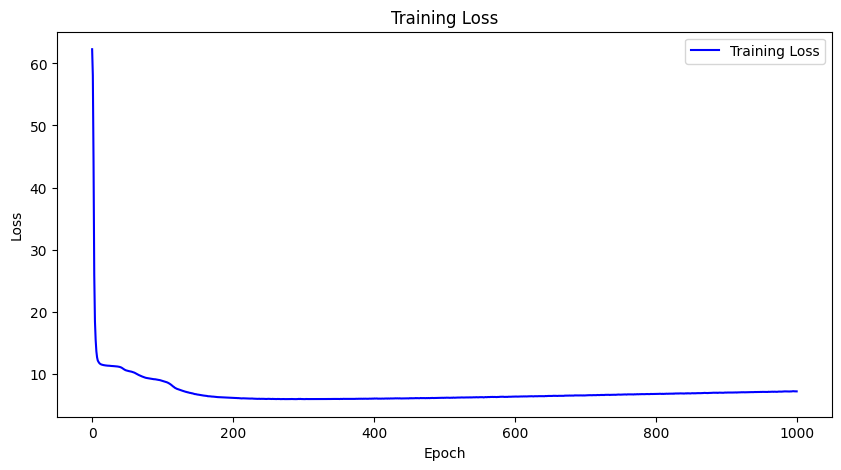

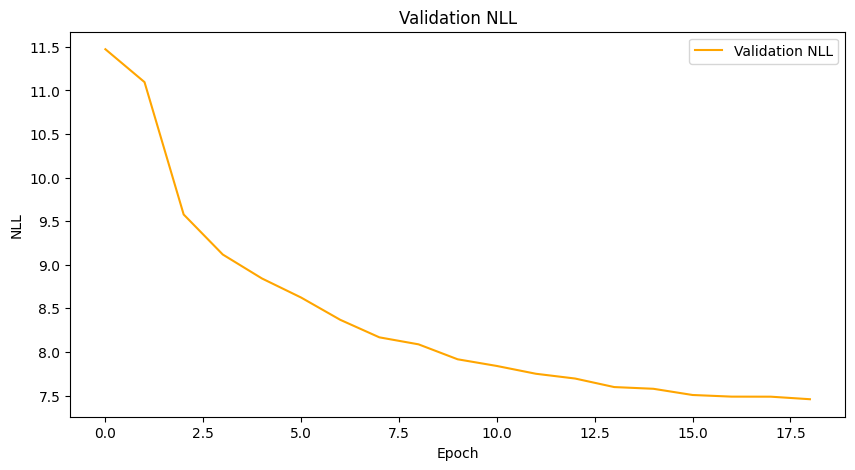

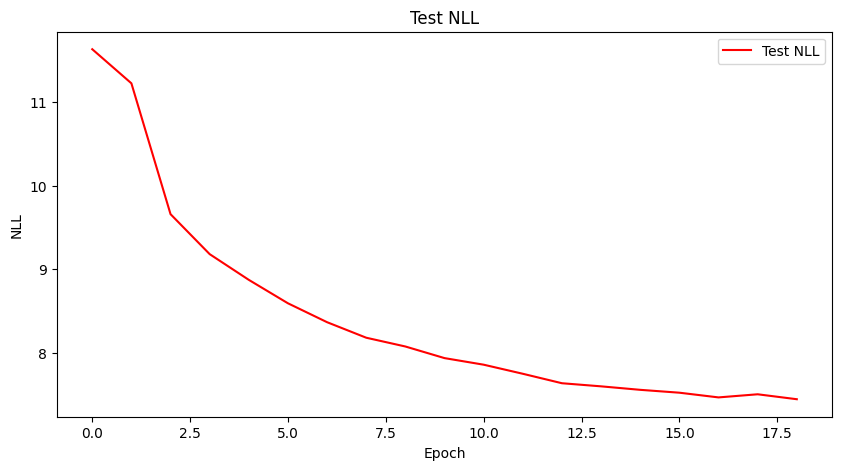

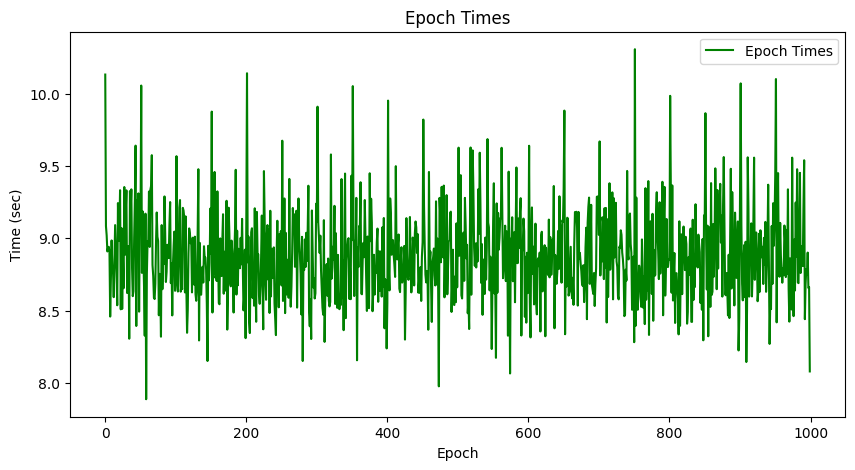

In [11]:
import re
import matplotlib.pyplot as plt

# Path to the log file
log_file_path = "/content/training.log"

# Regular expressions to match lines with the intended values
pattern_loss = re.compile(r"\[training epoch (\d{4})\].* (\d+\.\d+) \t")
pattern_val_test_nll = re.compile(r"\[val/test epoch (\d{4})\]  (\d+\.\d+)  (\d+\.\d+)")
pattern_epoch_time = re.compile(r"\(dt = (\d+\.\d+) sec\)")

# Lists to store extracted values
train_losses = []
val_nlls = []
test_nlls = []
epoch_times = []

# Function to plot the metrics
def plot_metric(metric_values, title, ylabel, color):
    plt.figure(figsize=(10, 5))
    plt.plot(metric_values, label=title, color=color)
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

with open(log_file_path, 'r') as log_file:
    for line in log_file:
        # Extract training loss
        match_loss = pattern_loss.search(line)
        if match_loss:
            train_loss = float(match_loss.group(2))
            train_losses.append(train_loss)

        # Extract validation and test NLL
        match_nll = pattern_val_test_nll.search(line)
        if match_nll:
            val_nll = float(match_nll.group(2))
            test_nll = float(match_nll.group(3))
            val_nlls.append(val_nll)
            test_nlls.append(test_nll)

        # Extract epoch times
        match_time = pattern_epoch_time.search(line)
        if match_time:
            epoch_time = float(match_time.group(1))
            epoch_times.append(epoch_time)

# Plot the extracted metrics
plot_metric(train_losses, "Training Loss", "Loss", "blue")
plot_metric(val_nlls, "Validation NLL", "NLL", "orange")
plot_metric(test_nlls, "Test NLL", "NLL", "red")
plot_metric(epoch_times, "Epoch Times", "Time (sec)", "green")